# Reproduce chi2 spectrum fit

I tried to reproduce the spectral fit I made with Christoph a few weeks ago using a new source.

## Load Data

In [33]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from pprint import pprint
import astropy.units as u
from astropy.units import Quantity

In [34]:
from gammapy.catalog import SourceCatalog3FGL, SourceCatalogObject3FGL

cat = SourceCatalog3FGL()

# This time I will pick "Dragonfly" as my source
source = cat['3FGL J2021.1+3651'] # a.k.a. PSR J2021+3651
data = source.flux_points.table

# Flux units
data['dnde'] = data['dnde'].to('cm-2 s-1 MeV-1')

# Create flux error
dnde_err = data['dnde'] * (data['flux_errn'] / data['flux'])
data['dnde_err'] = dnde_err.to(data['dnde'].unit)

data.info()

<Table length=5>
   name     dtype        unit      n_bad
---------- ------- --------------- -----
     e_ref float64             MeV     0
     e_min float64             MeV     0
     e_max float64             MeV     0
      flux float32     1 / (cm2 s)     0
 flux_errn float32     1 / (cm2 s)     0
 flux_errp float32     1 / (cm2 s)     0
     eflux float32   erg / (cm2 s)     0
eflux_errn float32   erg / (cm2 s)     0
eflux_errp float32   erg / (cm2 s)     0
     is_ul    bool                     0
   flux_ul float64     1 / (cm2 s)     5
  eflux_ul float64   erg / (cm2 s)     5
      dnde float64 1 / (cm2 MeV s)     0
  dnde_err float64 1 / (cm2 MeV s)     0


In [55]:
cols = ['e_ref', 'dnde', 'dnde_err']
data[cols]

# These will be the same for any source

e_ref,dnde,dnde_err
MeV,1 / (cm2 MeV s),1 / (cm2 MeV s)
float64,float64,float64
173.205080757,2.04104877602e-09,1.00411133777e-10
547.722557505,2.89106474074e-10,4.8425992587e-12
1732.05080757,2.83786952947e-11,4.31495275368e-13
5477.22557505,1.21403330155e-12,3.57664181501e-14
31622.7766017,2.56073757204e-15,3.5137554485e-16


In [56]:
print(source.spectral_model.parameters)
print(source.energy_range)

ParameterList
Parameter(name='index', value=1.6358338594436646, unit=Unit(dimensionless), min=0, max=None, frozen=False)
Parameter(name='amplitude', value=1.2799539206298505e-10, unit=Unit("1 / (cm2 MeV s)"), min=0, max=None, frozen=False)
Parameter(name='reference', value=838.4884033203125, unit=Unit("MeV"), min=None, max=None, frozen=0)
Parameter(name='ecut', value=3042.514404296875, unit=Unit("MeV"), min=None, max=None, frozen=False)

Covariance: None
[    100.  100000.] MeV


## Plot data and model

<Container object of 3 artists>

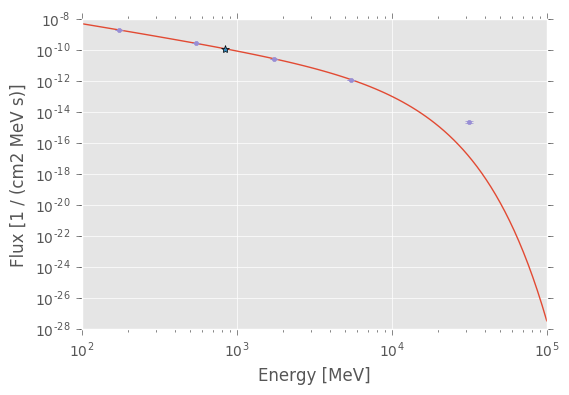

In [37]:
# Defining units
opts = dict(energy_unit='MeV', flux_unit='cm-2 s-1 MeV-1')

source.spectral_model.plot(source.energy_range, **opts)
# Spectral model used (PL, ECPL) based on the source's SpectrumType parameter

p = source.spectral_model.parameters

# Plot reference point
plt.plot(p['reference'].value, p['amplitude'].value, '*')

# Plot all data from source's FluxPoints
plt.errorbar(x=data['e_ref'],
             y = data['dnde'],
             yerr = data['dnde_err'],
             fmt='.'
            )

 ## Likelihood function - chi2

The chi2 function will determine the closeness of fit of our selected model (ECPL) to actual data.

In [38]:
source.spectral_model(p['reference'].quantity)  # quantity gets a value in Parameter class

<Quantity 1.2799539206298505e-10 1 / (cm2 MeV s)>

In [39]:
# Defining an ECPL model (same as Gammapy's)
# def dnde_model_ecpl(energy, amplitude, index, energy_cut, reference):
#     return amplitude * (energy / reference) ** (-index) * np.exp((reference -energy) / energy_cut)

# **Just use source.spectral_model.evaluate()**

In [49]:
# Defining chi2 function for this source
def chi2(amplitude, index, energy_cut):
    
    dnde_model = source.spectral_model.evaluate(
        energy=data['e_ref'],
        amplitude=amplitude,
        index=index,
        ecut=energy_cut,
        reference=838.4884033203125 # <-- this is e_ref minus the units
    ) 

    chi = (data['dnde'] - dnde_model) / data['dnde_err']
    return np.sum(chi ** 2)

In [48]:
# Test one example evaluation - we want the same result as source.spectral_model
# dnde_model_ecpl(
#     energy=e_ref,
#     amplitude=amp,
#     index=idx,
#     energy_cut = ecut,
#     reference=e_ref
# )

source.spectral_model.evaluate(
    energy=p['reference'].quantity,
    amplitude=p['amplitude'].quantity,
    index=p['index'].quantity,
    ecut=p['ecut'].quantity,
    reference=p['reference'].quantity
)

<Quantity 1.2799539206298505e-10 1 / (cm2 MeV s)>

## ML fit with Minuit

Maximum likelihood (ML) analysis. The analysis with Minuit will determine the best-fit model (optimizing the parameters of the ECPL model we feed in) that goes straight through all of the data points.

In [50]:
from iminuit import Minuit

pars = dict(amplitude=1.2799539206298505e-10, #amp value
            index=1.6358338594436646,         #idx value
            energy_cut=3042.514404296875
            )

minuit = Minuit(chi2, **pars)

minuit.print_initial_param()
print("^ Initial parameters")

minuit.migrad() # Performs the minimization
print("^ Optimized parameters for best-fit model")



C:\Users\arjun_000\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: InitialParamWarning: errordef is not given. Default to 1.
C:\Users\arjun_000\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: InitialParamWarning: Parameter amplitude is floating but does not have initial step size. Assume 1.
C:\Users\arjun_000\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: InitialParamWarning: Parameter index is floating but does not have initial step size. Assume 1.
C:\Users\arjun_000\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: InitialParamWarning: Parameter energy_cut is floating but does not have initial step size. Assume 1.


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,amplitude,1.27995e-10,1,0,0,,,
2,index,1.63583,1,0,0,,,
3,energy_cut,3042.51,1,0,0,,,


^ Initial parameters


FCN = 55.11415067891237 
 TOTAL NCALL = 71 
 NCALLS = 71 
 
 
 EDM = 4.4493011180702984e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,amplitude,1.27917e-10,1.58353e-12,0,0,,,
2,index,1.64734,0.026096,0,0,,,
3,energy_cut,2953.55,132.179,0,0,,,


^ Optimized parameters for best-fit model


In [51]:
pprint(minuit.values)
pprint(minuit.errors)

{'amplitude': 1.2791749556592422e-10,
 'energy_cut': 2953.5540418278893,
 'index': 1.6473432003473054}
{'amplitude': 1.5835329798426252e-12,
 'energy_cut': 132.17876069891886,
 'index': 0.026095972909697878}


## Final plot

Adding the fitted model to the plot from above.

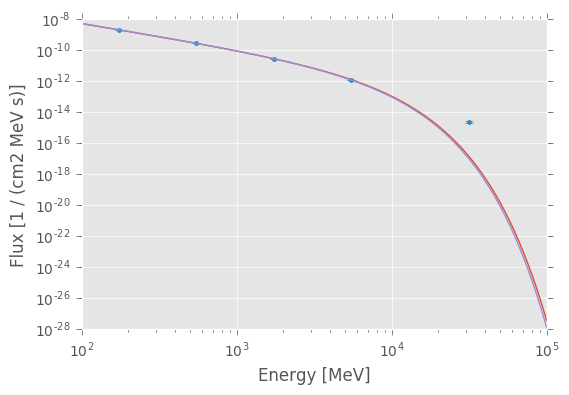

In [53]:
source.spectral_model.plot(source.energy_range, **opts)

plt.errorbar(x=data['e_ref'],
             y = data['dnde'],
             yerr = data['dnde_err'],
             fmt='.'
            )


from gammapy.utils.energy import Energy
energy = Energy.equal_log_spacing(
    emin=source.energy_range[0],
    emax=source.energy_range[1],
    nbins=100,
)


flux = source.spectral_model.evaluate(
    energy=energy.to('MeV').value,
    amplitude = minuit.values['amplitude'],
    index = minuit.values['index'],
    ecut = minuit.values['energy_cut'],
    reference=p['reference'].value,
)
plt.plot(energy, flux)